In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#Minhas Bibliotecas
import DatasetAnalise as faa
import CreateVariables as facv
import SolveNullsAndPreparationData as fanp
import ModelsAdvancedAnalysis as fam

#pip install tpot
import joblib
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tpot as tpt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#pip install pydotplus
#pip install graphviz
#conda install python-graphviz
import os
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
os.environ["PATH"] += os.pathsep + 'C:\\Users\\alexa\\anaconda3\\Library\\bin\\graphviz'

import random
import sys

2020-07-07 00:04:02,129 [INFO]  NumExpr defaulting to 4 threads.


# Carrega as bases necessárias

In [2]:
versao = '_v1'
pre_tratamento = '_processado'
nome_alvo = 'Survived'

#Dados de entradas de treino
df = pd.read_csv('bases/train' + pre_tratamento + versao + '.csv')

#Coloca a coluna de resposta no final
df = faa.colocaAlvoComeco(df, nome_alvo)

#Dados de entrada de teste
df_test = pd.read_csv('bases/test' + pre_tratamento + versao + '.csv')

#Dados das soluções dos dados de teste (modelo de submissão)
df_gender = pd.read_csv('submissoes/gender_submission.csv')

#Faz as coisas serem realmente aleatórias
seedValue = random.randrange(sys.maxsize)
random.seed(seedValue)

In [3]:
#Configura parâmetros estatísticos
num_loop = 5
#EXPLICAÇÃO: O loop de treino e validação serve para medirmos o comportamento médio e o desvio do modelo quando estamos
            #dentro e fora da base de treino
#OBS: Note que se o desempenho não for dentro da faixa esperada, provavelmente é pq as regras mudaram no dataset de test!!!

#Configura se iremos usar algum tipo de balanceamento nas divisões entre treino e validação
balanced = 2

#Configura fração que usamos para buscar modelos (Tpot e GridSearch)
frac_search = 0.5
#EXPLICAÇÃO: Quando usamos uma determinada equação para ajustar dados, a forma da equação é dado por uma teoria.
            #Nesse caso não temos uma teoria, então estamos usando os próprios dados para estimar a equação adequada,
            #"criar a teoria", assim se usamos o dataset inteiro para isso, vamos encontrar uma equação muito específica 
            #para o problema, e não uma equação de "teoria geral".
#OBS: Acho que o ideal seria se tivesse como rodar diversas vezes a busca para frações do dataset e ver a "equação média".
    #Será que o Tpot já não faz isso? (ESTUDAR O QUE O TPOT FAZ, PRA VER SE POSSO COLOCAR frac_search = 1.0 SEM MEDO!!!)

# Funções da lista de modelos treinados

In [4]:
def insere_modelo(df_modelos, nome, clf):
    if(len(df_modelos[df_modelos['nome'] == nome]) == 0):
        df_modelos.loc[len(df_modelos)] = [nome, clf, np.nan, np.nan, np.nan, np.nan]
    else:
        df_modelos.loc[df_modelos[df_modelos['nome'] == nome].index, :] = [nome, clf, np.nan, np.nan, np.nan, np.nan]
      
def insere_acuracia(df_modelos, nome, df_metr): 
    if(len(df_modelos[df_modelos['nome'] == nome]) != 0):
        df_modelos['acuracia'][df_modelos[df_modelos['nome'] == nome].index[0]] = df_metr['valor']['Acurácia']
        df_modelos['erro'][df_modelos[df_modelos['nome'] == nome].index[0]] = df_metr['erro']['Acurácia']
        df_modelos['fator_qual'][df_modelos[df_modelos['nome'] == nome].index[0]] = df_metr['valor']['Fator_Qual']
        df_modelos['fator_erro'][df_modelos[df_modelos['nome'] == nome].index[0]] = df_metr['erro']['Fator_Qual']

def get_modelo(df_modelos, nome):
    if(len(df_modelos[df_modelos['nome'] == nome]) != 0):
        model = df_modelos[df_modelos['nome'] == nome].iloc[0, 1]
        return model

def find_best_model(df_modelos):
    indice = df_modelos[df_modelos['acuracia'] == df_modelos['acuracia'].max()].index[0]
    acuracia_max = df_modelos['acuracia'][indice]
    erro_max = df_modelos['erro'][indice]
    df_sub = pd.DataFrame(columns = ['indice', 'fator_qual', 'fator_erro'])
    df_sub.loc[len(df_sub)] = [indice, df_modelos['fator_qual'][indice], df_modelos['fator_erro'][indice]]
    for i in range(0, len(df_modelos)):
        if(i != indice and df_modelos['acuracia'][i] + df_modelos['erro'][i] > acuracia_max - erro_max):
            df_sub.loc[len(df_sub)] = [i, df_modelos['fator_qual'][i], df_modelos['fator_erro'][i]]
    indice_final = df_sub[df_sub['fator_qual'] == df_sub['fator_qual'].min()].iloc[0, 0]
    best_model = df_modelos.loc[indice, 'nome']
    return best_model

df_modelos1 = pd.DataFrame(columns = ['nome', 'modelo', 'acuracia', 'erro', 'fator_qual', 'fator_erro'])

# Chute (Referência)

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 49.2 ± 3.1
Acurácia Validação: 50.1 ± 1.9
Queda de Acurácia: -1.0 ± 4.0


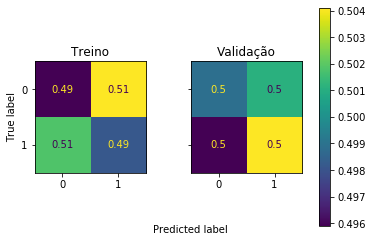

----------------------
ROC Treino: 50.0 ± 0.0
ROC Validação: 50.0 ± 0.0
Queda de ROC: 0.0 ± 0.0


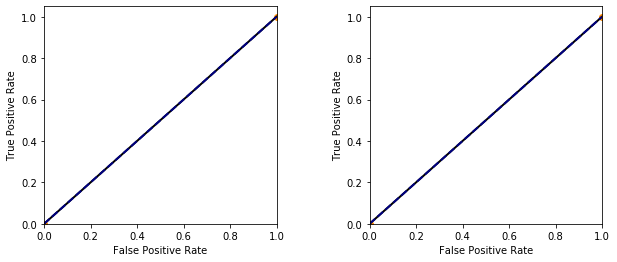

----------------------
KS Treino: 0.0 ± 0.0
KS Validação: 0.0 ± 0.0
Queda de KS: 0.0 ± 0.0


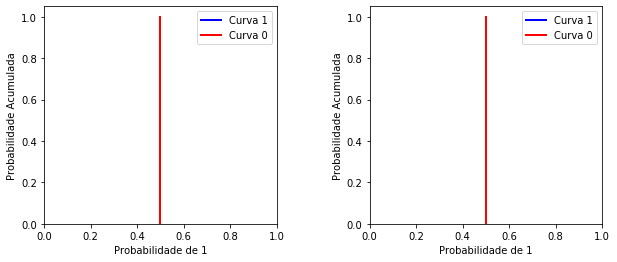

----------------------
Melhor Prob Corte Treino: 100.0 ± 0.0
Melhor Prob Corte Validação: 100.0 ± 0.0
Queda de Melhor Prob Corte: 0.0 ± 0.0
----------------------
Melhor Acurácia Treino: 50.0 ± 0.0
Melhor Acurácia Validação: 50.0 ± 0.0
Queda de Melhor Acurácia: 0.0 ± 0.0
 
****Avaliação por Quantidade de Treino****


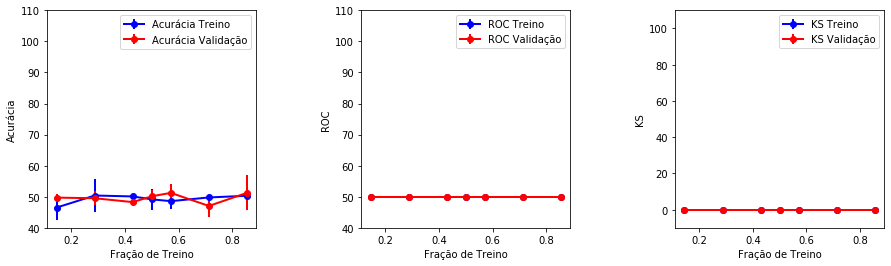

---------Evolução Ajustando Probabilidade de Corte---------


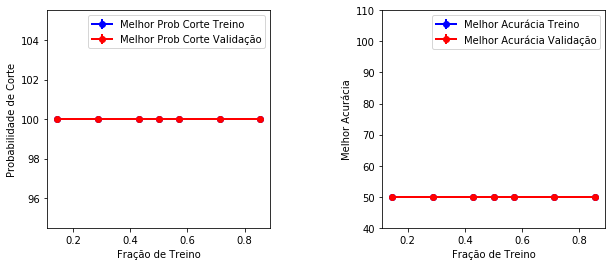

---------Valores Esperados---------
Acurácia: 50.7 ± 5.9
ROC: 50.0 ± 0.0
KS: 0.0 ± 0.0
Melhor Prob Corte: 100.0 ± 0.0
Melhor Acurácia: 50.0 ± 0.0
Fator de Qualidade: nan ± 0


In [5]:
fam.avaliaModeloChute(df, nome_alvo, balanced, num_loop)
#A ideia aqui é ver como fica quando nosso modelo é apenas chutar
#Esse é o modelo mais estável possível, mas chutar é fácil
#Queremos um modelo que faça nosso resultado ser melhor que o chute, sem ganhar muita instabilidade com isso
#Ou seja, tem que ser melhor que um chute e genérico o suficiente para funcionar para outros dados
#Por isso, vamos definir um fator de qualidade: 
#Quantidade de Acurácia maior que o chute (acuracia - 0.5) dividido pela queda de desempenho fora do treino

# Cria base auxiliar para o modelo sem nulos

In [6]:
df_aux = fanp.removeVarsCabins(df).copy()
df_test_aux = fanp.removeVarsCabins(df_test).copy()

# Decision Tree

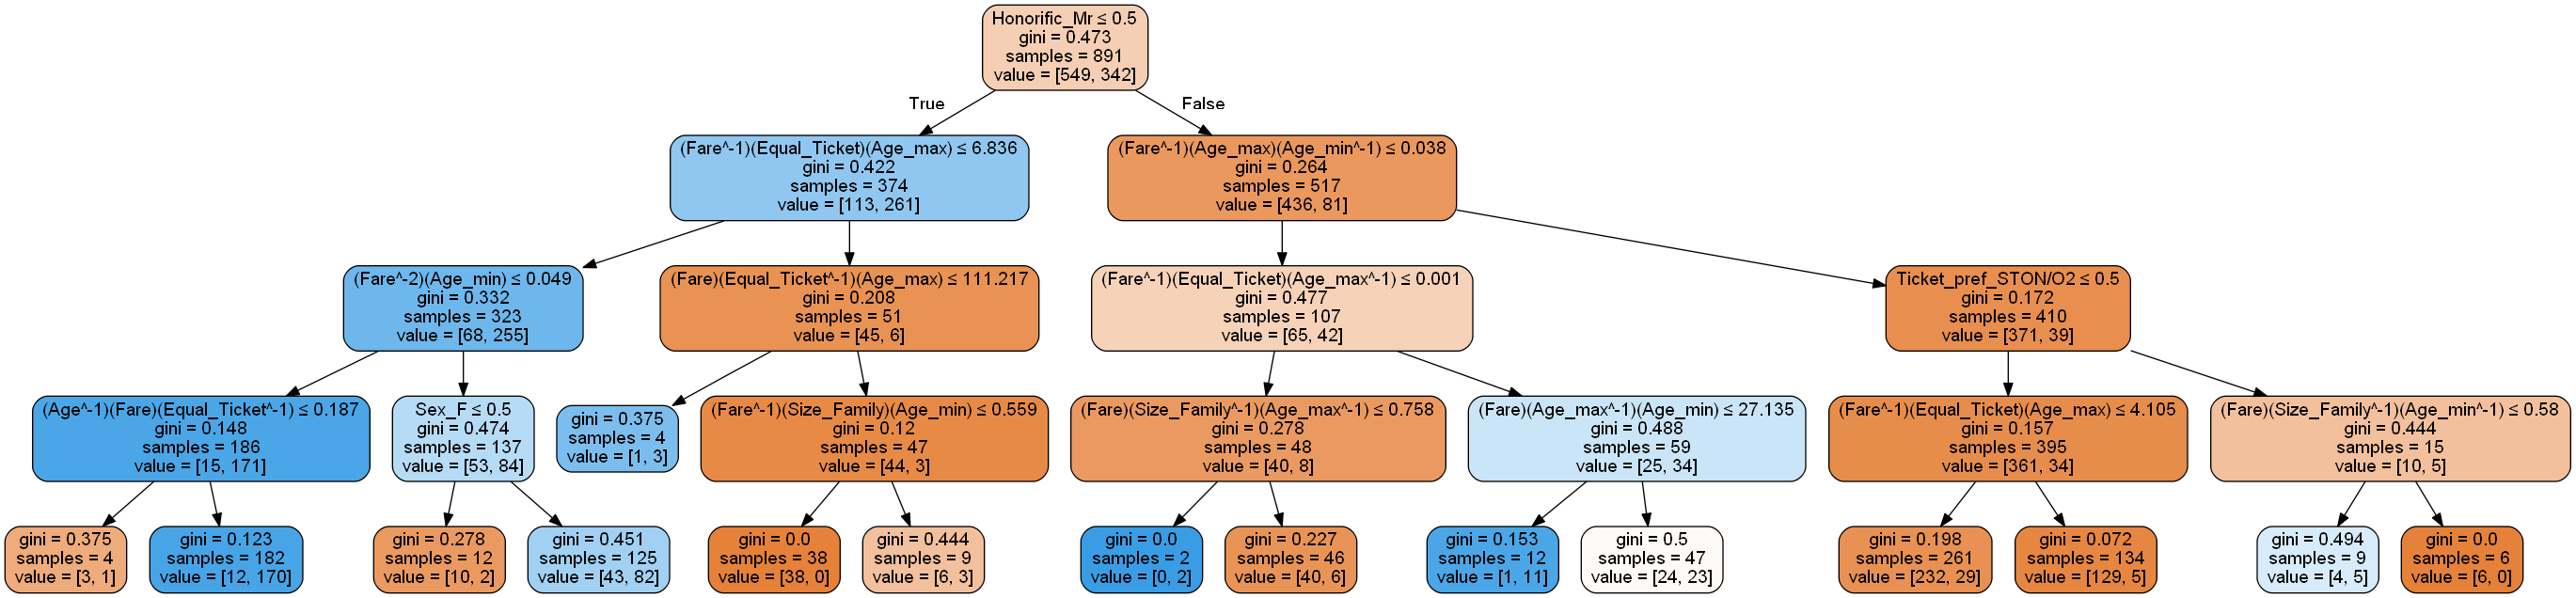

In [7]:
clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 10)
clf = clf.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])
insere_modelo(df_modelos1, 'Decision Tree', clf)

dot_data = StringIO()
export_graphviz(clf, out_file = dot_data,  filled = True, rounded = True, special_characters = True,
               feature_names = list(df_aux.drop(nome_alvo, axis = 1).columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 86.0 ± 1.6
Acurácia Validação: 78.6 ± 2.1
Queda de Acurácia: 7.4 ± 2.9


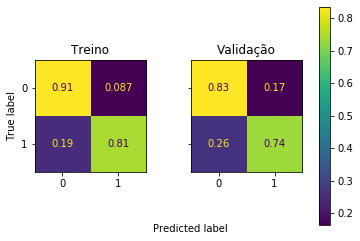

----------------------
ROC Treino: 91.9 ± 1.0
ROC Validação: 83.5 ± 1.1
Queda de ROC: 8.3 ± 1.7


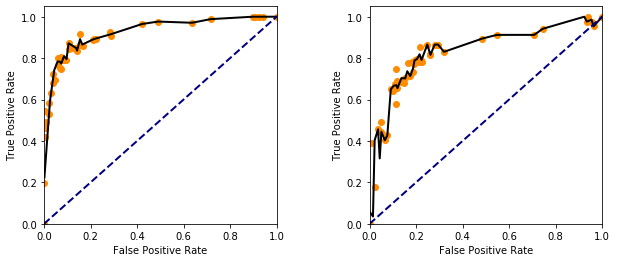

----------------------
KS Treino: 72.5 ± 2.8
KS Validação: 61.2 ± 2.2
Queda de KS: 11.3 ± 4.1


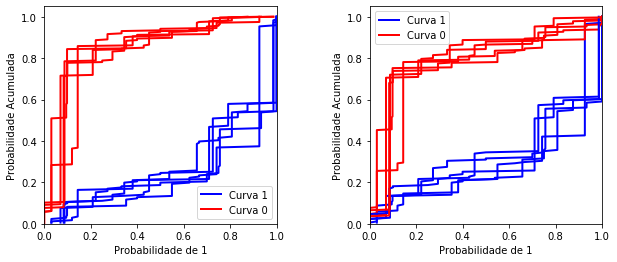

----------------------
Melhor Prob Corte Treino: 45.3 ± 5.6
Melhor Prob Corte Validação: 43.4 ± 14.9
Queda de Melhor Prob Corte: 2.0 ± 18.6
----------------------
Melhor Acurácia Treino: 86.3 ± 1.4
Melhor Acurácia Validação: 80.6 ± 1.1
Queda de Melhor Acurácia: 5.6 ± 2.1
 
****Avaliação por Quantidade de Treino****


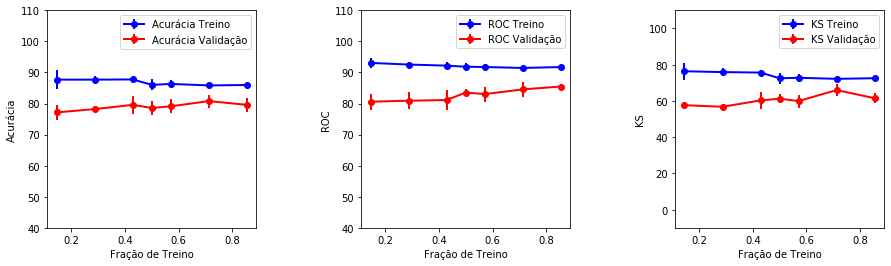

---------Evolução Ajustando Probabilidade de Corte---------


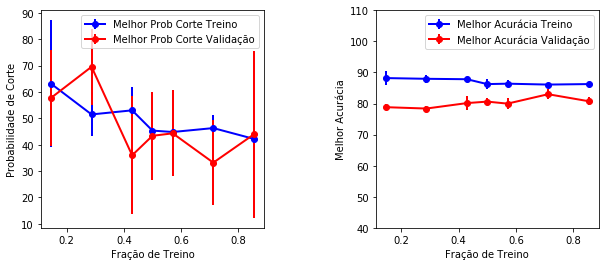

---------Valores Esperados---------
Acurácia: 77.3 ± 3.4
ROC: 82.5 ± 2.7
KS: 59.2 ± 6.2
Melhor Prob Corte: 45.5 ± 27.9
Melhor Acurácia: 79.6 ± 3.1
Fator de Qualidade: 0.26 ± 0.07


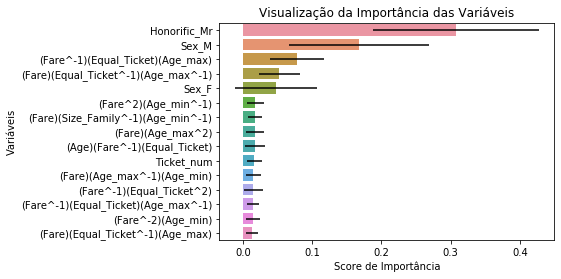

In [8]:
df_metr, _ = fam.avaliaModelos([clf], df_aux, nome_alvo, balanced, num_loop, flag_print = True)
insere_acuracia(df_modelos1, 'Decision Tree', df_metr)

# Random Forest

In [9]:
clf = RandomForestClassifier(n_estimators = 300, max_depth = 5, min_samples_split = 5, min_samples_leaf = 3, n_jobs = -1)

clf = clf.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])
insere_modelo(df_modelos1, 'Random Forest', clf)

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 89.4 ± 1.2
Acurácia Validação: 80.4 ± 1.8
Queda de Acurácia: 9.0 ± 2.6


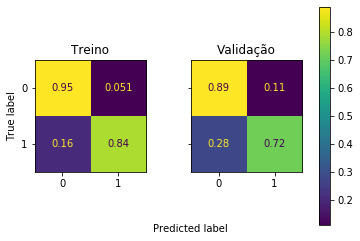

----------------------
ROC Treino: 96.4 ± 0.5
ROC Validação: 86.8 ± 1.3
Queda de ROC: 9.6 ± 1.8


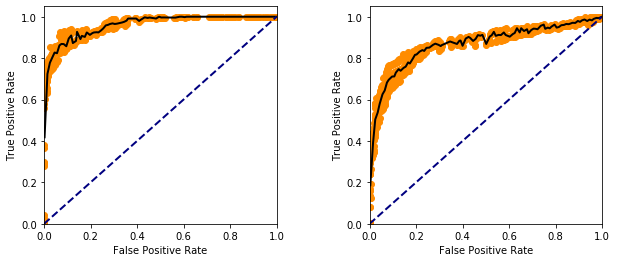

----------------------
KS Treino: 81.4 ± 3.1
KS Validação: 64.1 ± 2.2
Queda de KS: 17.3 ± 5.1


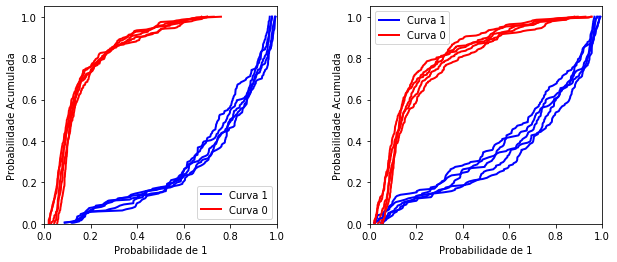

----------------------
Melhor Prob Corte Treino: 47.0 ± 6.8
Melhor Prob Corte Validação: 42.3 ± 11.9
Queda de Melhor Prob Corte: 4.7 ± 12.7
----------------------
Melhor Acurácia Treino: 90.7 ± 1.5
Melhor Acurácia Validação: 82.0 ± 1.1
Queda de Melhor Acurácia: 8.6 ± 2.6
 
****Avaliação por Quantidade de Treino****


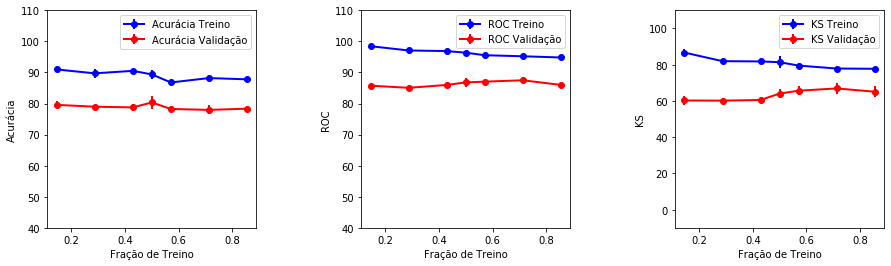

---------Evolução Ajustando Probabilidade de Corte---------


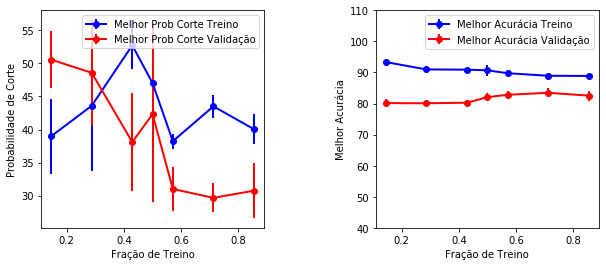

---------Valores Esperados---------
Acurácia: 77.3 ± 1.8
ROC: 85.0 ± 1.6
KS: 60.0 ± 5.8
Melhor Prob Corte: 37.6 ± 12.3
Melhor Acurácia: 80.0 ± 2.9
Fator de Qualidade: 0.36 ± 0.05


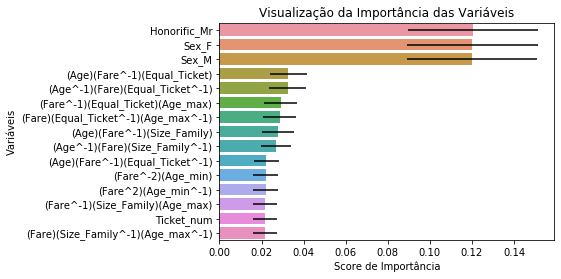

In [10]:
df_metr, _ = fam.avaliaModelos([clf], df_aux, nome_alvo, balanced, num_loop, flag_print = True)
insere_acuracia(df_modelos1, 'Random Forest', df_metr)

# XGBoost

In [11]:
clf = xgb.XGBClassifier(max_depth = 3, booster = 'gbtree', sub_sample = 0.08, n_estimators = 150,
                       learn_rate = 0.1, n_jobs = -1, objective = 'binary:logistic', colsample_bytree = 0.9, verbosity = 0)

df1 = df_aux.sample(frac = 0.5, replace = False).copy()
df2 = df_aux.drop(df1.index).copy()
eval_set = [(df1.drop(nome_alvo, axis = 1), df1[nome_alvo]), (df2.drop(nome_alvo, axis = 1), df2[nome_alvo])]
clf.fit(df1.drop(nome_alvo, axis = 1), df1[nome_alvo].values.ravel(),
        early_stopping_rounds = 10, eval_metric = ["error", "logloss"], eval_set = eval_set, verbose = False)

insere_modelo(df_modelos1, 'XGBoost', clf)

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 99.7 ± 0.2
Acurácia Validação: 79.9 ± 1.0
Queda de Acurácia: 19.8 ± 0.8


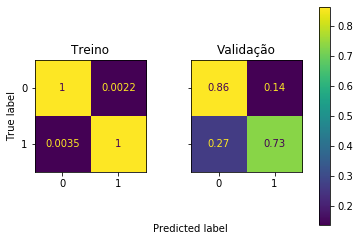

----------------------
ROC Treino: 100.0 ± 0.0
ROC Validação: 86.7 ± 0.8
Queda de ROC: 13.3 ± 0.8


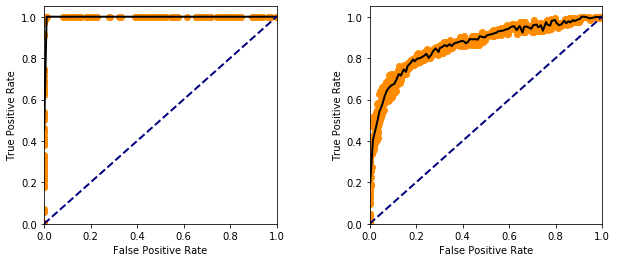

----------------------
KS Treino: 99.7 ± 0.3
KS Validação: 62.0 ± 1.2
Queda de KS: 37.7 ± 1.3


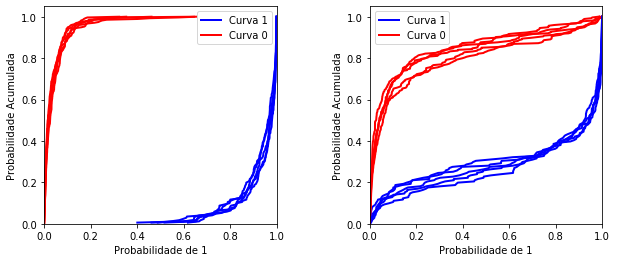

----------------------
Melhor Prob Corte Treino: 49.8 ± 7.2
Melhor Prob Corte Validação: 49.3 ± 11.6
Queda de Melhor Prob Corte: 0.4 ± 9.5
----------------------
Melhor Acurácia Treino: 99.9 ± 0.1
Melhor Acurácia Validação: 81.0 ± 0.6
Queda de Melhor Acurácia: 18.8 ± 0.6
 
****Avaliação por Quantidade de Treino****


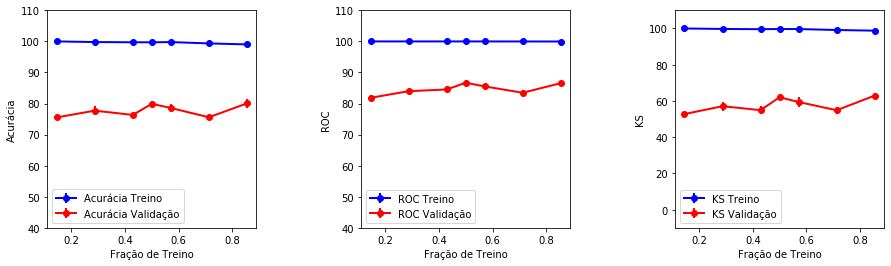

---------Evolução Ajustando Probabilidade de Corte---------


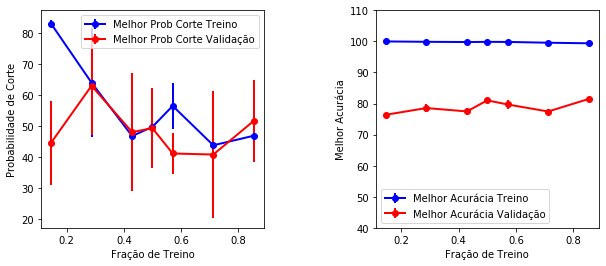

---------Valores Esperados---------
Acurácia: 77.0 ± 2.0
ROC: 85.1 ± 1.5
KS: 57.8 ± 3.8
Melhor Prob Corte: 36.3 ± 21.5
Melhor Acurácia: 78.9 ± 1.9
Fator de Qualidade: 0.79 ± 0.1


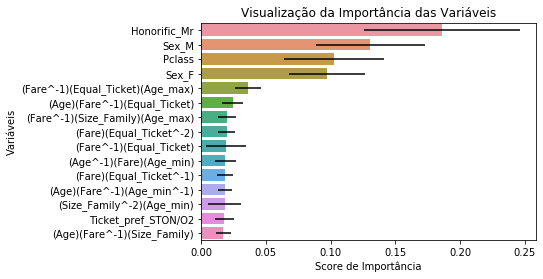

In [12]:
df_metr, _ = fam.avaliaModelos([clf], df_aux, nome_alvo, balanced, num_loop, flag_print = True)
insere_acuracia(df_modelos1, 'XGBoost', df_metr)

# Tpot

In [13]:
tpot = tpt.TPOTClassifier(generations = 3, 
                          population_size = 40, 
                          cv = 5, 
                          subsample = frac_search, 
                          n_jobs = -1, 
                          verbosity = 2)

tpot.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])

clf = tpot.fitted_pipeline_.steps[-1][1]
clf.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])

insere_modelo(df_modelos1, 'Tpot', clf)

2020-07-07 00:06:29,167 [WARNING]  Code block execution exceeded 2 seconds timeout
Traceback (most recent call last):
  File "C:\Users\alexa\AppData\Roaming\Python\Python37\site-packages\stopit\utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "C:\Users\alexa\AppData\Roaming\Python\Python37\site-packages\tpot\decorators.py", line 57, in time_limited_call
    func(*args)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 350, in fit
    Xt, fit_params = self._fit(X, y, **fit_params)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 315, in _fit
    **fit_params_steps[name])
  File "C:\Users\alexa\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 728, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\alexa\anaconda3\lib\site-packages

2020-07-07 00:07:15,439 [WARNING]  Code block execution exceeded 2 seconds timeout
Traceback (most recent call last):
  File "C:\Users\alexa\AppData\Roaming\Python\Python37\site-packages\stopit\utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "C:\Users\alexa\AppData\Roaming\Python\Python37\site-packages\tpot\decorators.py", line 57, in time_limited_call
    func(*args)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 350, in fit
    Xt, fit_params = self._fit(X, y, **fit_params)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 315, in _fit
    **fit_params_steps[name])
  File "C:\Users\alexa\anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\alexa\anaconda3\lib\site-packages\sklearn\pipeline.py", line 728, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\alexa\anaconda3\lib\site-packages


Generation 1 - Current best internal CV score: 0.8292134831460676
Generation 2 - Current best internal CV score: 0.8292134831460676
Generation 3 - Current best internal CV score: 0.8292134831460676
Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.5, min_samples_leaf=8, min_samples_split=18, n_estimators=100)


'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 84.6 ± 0.7
Acurácia Validação: 80.6 ± 1.1
Queda de Acurácia: 4.0 ± 1.5


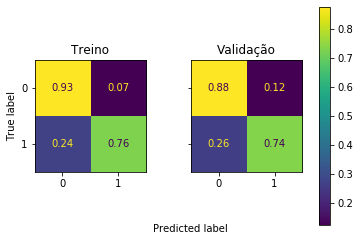

----------------------
ROC Treino: 94.4 ± 0.5
ROC Validação: 87.5 ± 1.2
Queda de ROC: 6.9 ± 1.6


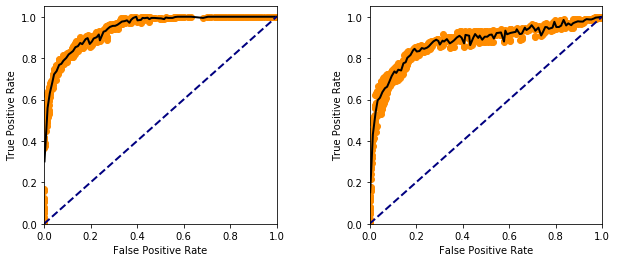

----------------------
KS Treino: 72.7 ± 1.4
KS Validação: 65.4 ± 1.0
Queda de KS: 7.4 ± 2.4


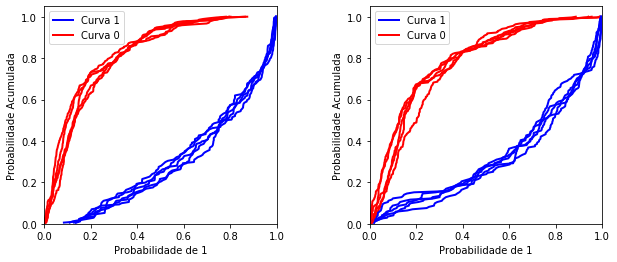

----------------------
Melhor Prob Corte Treino: 40.9 ± 4.9
Melhor Prob Corte Validação: 41.0 ± 3.3
Queda de Melhor Prob Corte: -0.1 ± 6.5
----------------------
Melhor Acurácia Treino: 86.4 ± 0.7
Melhor Acurácia Validação: 82.7 ± 0.5
Queda de Melhor Acurácia: 3.7 ± 1.2
 
****Avaliação por Quantidade de Treino****


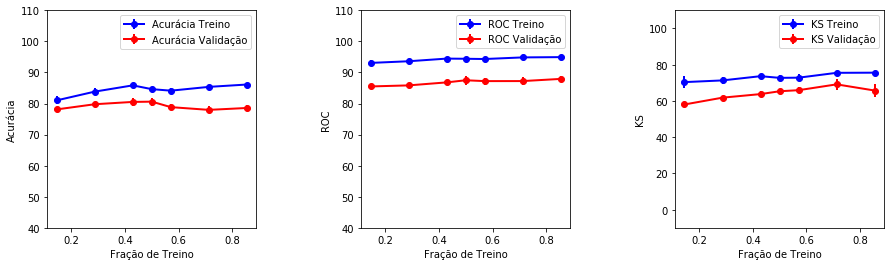

---------Evolução Ajustando Probabilidade de Corte---------


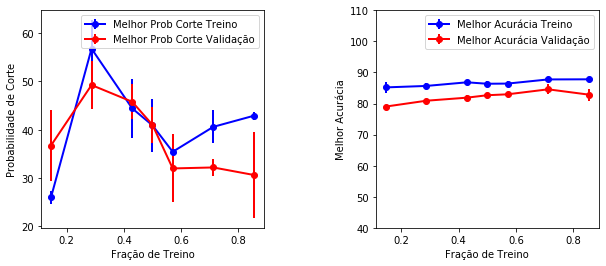

---------Valores Esperados---------
Acurácia: 80.2 ± 2.1
ROC: 87.7 ± 1.0
KS: 66.0 ± 4.1
Melhor Prob Corte: 36.9 ± 9.0
Melhor Acurácia: 83.0 ± 2.1
Fator de Qualidade: 0.2 ± 0.06


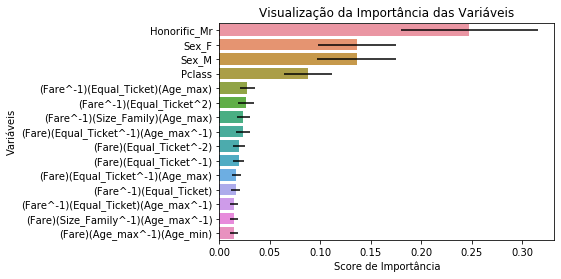

In [14]:
df_metr, _ = fam.avaliaModelos([clf], df_aux, nome_alvo, balanced, num_loop, flag_print = True)
insere_acuracia(df_modelos1, 'Tpot', df_metr)

# MLP - GridSearch

In [15]:
parameters = {'solver': ['lbfgs'], 
              'max_iter': [1000,1100,1200], 
              'alpha': 10.0 ** -np.arange(1, 3), 
              'hidden_layer_sizes': np.arange(10, 12), 
              'random_state': [0,1,2,3]}
grids = GridSearchCV(MLPClassifier(), parameters, cv = 2, n_jobs = -1, verbose = 1)
df_search = df_aux.sample(frac = frac_search, replace = False).copy()
grids.fit(df_search.drop(nome_alvo, axis = 1), df_search[nome_alvo])

clf = MLPClassifier(**grids.best_params_)
clf.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])
insere_modelo(df_modelos1, 'MLP', clf)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    5.5s finished


'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 59.1 ± 5.2
Acurácia Validação: 56.7 ± 4.2
Queda de Acurácia: 2.4 ± 1.6


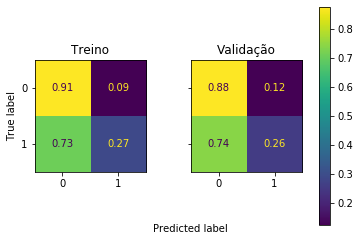

----------------------
ROC Treino: 59.2 ± 6.3
ROC Validação: 55.2 ± 4.8
Queda de ROC: 4.0 ± 3.3


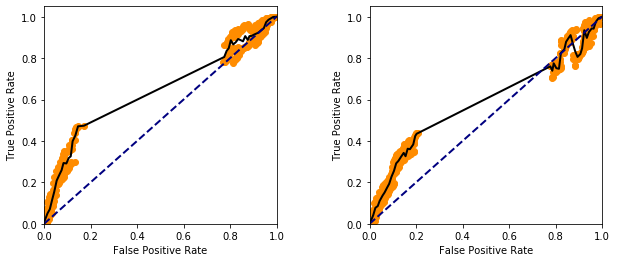

----------------------
KS Treino: 19.5 ± 11.3
KS Validação: 15.1 ± 8.4
Queda de KS: 4.5 ± 4.0


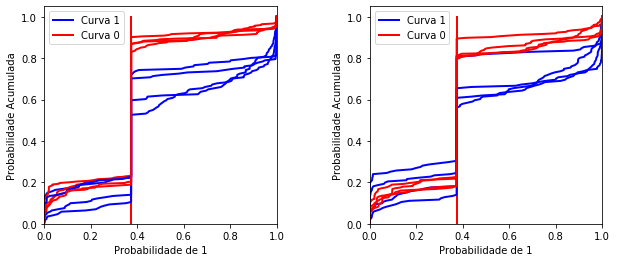

----------------------
Melhor Prob Corte Treino: 51.9 ± 17.9
Melhor Prob Corte Validação: 70.4 ± 19.1
Queda de Melhor Prob Corte: -18.5 ± 20.8
----------------------
Melhor Acurácia Treino: 59.8 ± 5.7
Melhor Acurácia Validação: 57.3 ± 4.3
Queda de Melhor Acurácia: 2.4 ± 2.1
 
****Avaliação por Quantidade de Treino****


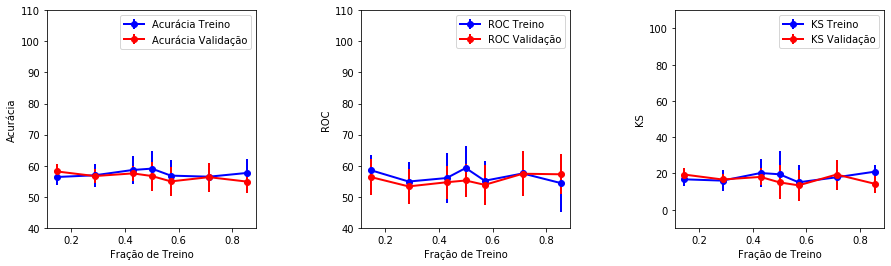

---------Evolução Ajustando Probabilidade de Corte---------


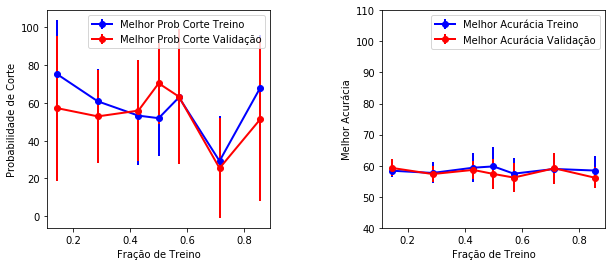

---------Valores Esperados---------
Acurácia: 53.0 ± 6.1
ROC: 47.9 ± 9.8
KS: 9.3 ± 13.2
Melhor Prob Corte: 41.1 ± 39.4
Melhor Acurácia: 53.8 ± 6.5
Fator de Qualidade: nan ± 0
Não tem feature_importances


In [16]:
df_metr, _ = fam.avaliaModelos([clf], df_aux, nome_alvo, balanced, num_loop, flag_print = True)
insere_acuracia(df_modelos1, 'MLP', df_metr)

# Avaliação do melhor modelo

In [17]:
#Pega o melhor modelo
melhor_modelo1 = find_best_model(df_modelos1)
max_acuracia1 = df_modelos1[df_modelos1['nome'] == melhor_modelo1].iloc[0, 2]
erro1 = df_modelos1[df_modelos1['nome'] == melhor_modelo1].iloc[0, 3]

print(melhor_modelo1 + ': ' + str(round(max_acuracia1*100, 1)) + ' ' + u"\u00B1" + ' ' + str(round(erro1*100, 1)))
model1 = get_modelo(df_modelos1, melhor_modelo1)
print('*******************')

cv1 = np.where(melhor_modelo1 == 'XGBoost', True, False)

Tpot: 80.2 ± 2.1
*******************


# Cria arquivo de submissão

In [18]:
df_final = df_gender.copy()
df_final['Survived'] = model1.predict(df_test_aux)
df_final.to_csv('submissoes/gender_submission' + versao + '.csv', index = False)
#df_final